The objective of this jupyter notebook is to count the distinct structures for 2 Al atoms in one cell with 72 T sites.

The codes have 14 sections.  
1. Modification of ATAT  
2. Prepare lattice input file (lat.in)  
3. Read lattice input file (lat.in)  
4. Functions to convert between fractional coordinates and xyz coordinates  
5. Prepare structure requirements input file (str_req.txt)  
6. Read structure requirements input file (str_req.txt)  
7. Function to find the site index for any given fractional coordinates  
8. Create str.out file  
9. Run corrdump to generate cluster list into cluster_list.csv file  
10. Read cluster_list.csv  
11. Count distinct structures for 2Al atoms 

#### 1. Modification of ATAT

Before we run the codes, we have to modify ATAT files to output the cluster list when we run corrdump to count clusters. Corrdump has many parameters. Here we will only set the maximum distance between two points within a pair (-2=[real]), with other parameters being default. The modification of ATAT contains 2 parts: one is in calccorr.c++ file and the other is in corrdump.c++ file. After the modifications, **corrdump will output the xyz coordinates for all the clusters in a structure inspite of the atom occupations.**

Note: If you also want to set other parameters, you may need to make more modifications.

a) In file calccorr.c++, please modify the following function (around line 200) as below. The modified lines have comments at the end.

b) In file corrdump.c++, please modify the following code block (around line 460). The modified lines have comments at the end.

c) After you modify the ATAT codes, you have to reinstall the ATAT **in terminal**. It should contain the following two commands.

Python codes start here

In [1]:
import pandas as pd
import numpy as np
import copy
from math import *
import os
import random
from collections import defaultdict
import csv
from functools import reduce
from copy import deepcopy
import pickle
from timeit import default_timer as timer
from matplotlib import pyplot as plt
%matplotlib inline

#### 2. Prepare lattice input file (lat.in)

The input file of lat.in contains the lattice parameters and all the possible types of atoms at each site. The detailed format of lat.in can be found in the ATAT manual (https://www.brown.edu/Departments/Engineering/Labs/avdw/atat/manual.pdf) pg. 36.  
 
The following information is from ATAT manual.  
Lattice file format:  
First, the coordinate system a,b,c is specified, either as  
[a] [b] [c] [alpha] [beta] [gamma]  

Then the lattice vectors u,v,w are listed, expressed in the coordinate system   just defined:  
[ua] [ub] [uc]  
[va] [vb] [vc]  
[wa] [wb] [wc]  

Finally, atom positions and types are given, expressed in the same coordinate system   as the lattice vectors:  
[atom1a] [atom1b] [atom1c] [atom1type]  
[atom2a] [atom2b] [atom2c] [atom2type]  
etc.  

In the lattice file:  
-The atom type is a comma-separated list of the atomic  
symbols of the atoms that can sit the lattice site.  
-In a binary, the first symbol listed is assigned a spin of -1.  
In general, ordering of the atom symbol corresponds to value of s=0,1,... in the table  
’Convention used to calculate the correlations’ below.  
-When only one symbol is listed, this site is ignored for the purpose  
of calculating correlations, but not for determining symmetry.  
-The atomic symbol ’Vac’ or ’Va’ is used to indicate a vacancy.  

#### 3. Read lattice input file (lat.in)
Read lat.in file and create a lattice dictionary which contains the lattice parameters, lattice vectors and fractional coordinates of all the sites in the lattics.

In [54]:
lattice_sites.head()

,a,b,c,atom
0,0.3201,0.0918,0.12505,O
0,0.8201,0.5918,0.37505,O
0,0.6799,0.0918,0.12505,O
0,0.1799,0.5918,0.37505,O
0,0.3201,0.9082,0.12505,O


In [2]:
filepath='lat.in'
file = open(filepath, 'r')
lat = file.readlines()

lattice = {}
lattice['a'], lattice['b'], lattice['c'], lattice['alpha'], lattice['beta'], lattice['gamma'] = [float(number) for number in lat[0].split()]
lattice['u'] = [int(number) for number in lat[1].split()]
lattice['v'] = [int(number) for number in lat[2].split()]
lattice['w'] = [int(number) for number in lat[3].split()]

lattice_sites = pd.DataFrame(columns=['a', 'b', 'c', 'atom'])
for line in lat[4:]:
    site = line.split()[:3]
    atom_type = ''
    for atom in line.split()[3:]:
        atom_type += str(atom)
    site.append(atom_type)
    lattice_sites = lattice_sites.append(pd.DataFrame([site], columns=['a', 'b', 'c', 'atom']))
lattice_sites = lattice_sites.apply(pd.to_numeric, errors = 'ignore')

In [3]:
lattice

{'a': 19.018,
 'alpha': 90.0,
 'b': 14.303,
 'beta': 90.0,
 'c': 15.082,
 'gamma': 90.0,
 'u': [1, 0, 0],
 'v': [0, 1, 0],
 'w': [0, 0, 1]}

In [4]:
lattice_sites.head()

,a,b,c,atom
0,0.3201,0.0918,0.12505,O
0,0.8201,0.5918,0.37505,O
0,0.6799,0.0918,0.12505,O
0,0.1799,0.5918,0.37505,O
0,0.3201,0.9082,0.12505,O


#### 4. Functions to convert between fractional coordinates and xyz coordinates

In [5]:
def lattice_axes_xyz(lattic):
    '''
    function to prepare the xyz axes (a matrix)
                [ax] [ay] [az]
    axes_xyz =  [bx] [by] [bz]
                [cx] [cy] [cz]
    '''
    a = np.array([1,0,0]) * lattice['a']
    b = np.array([cos(lattice['gamma']/180*pi), sin(lattice['gamma']/180*pi), 0]) * lattice['b']
    c = np.cross(a, b)/np.linalg.norm(np.cross(a, b)) * lattice['c']
    return np.array((a,b,c))

In [6]:
def lattice_axes_abc(lattice):
    '''
    function to prepare the abc axes (a matrix)
                [ua] [ub] [uc]
    axes_abc =  [va] [vb] [vc]
                [wa] [wb] [wc]
    '''
    return np.array((lattice['u'], lattice['v'], lattice['w']))

In [7]:
def frac_to_xyz(axes_xyz, frac_coor):
    '''
    function to convert fractional coordinates to xyz coordinates
    '''
    return np.dot(frac_coor, axes_xyz)

In [8]:
def xyz_to_frac(axes_xyz, xyz_coor):
    '''
    function to convert xyz coordinates to fractional coordinates
    '''
    return np.dot(xyz_coor, np.linalg.inv(axes_xyz))

In [9]:
axes_abc = lattice_axes_abc(lattice)

In [10]:
axes_abc

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])

In [11]:
axes_xyz = lattice_axes_xyz(lattice)

In [12]:
axes_xyz

array([[1.90180000e+01, 0.00000000e+00, 0.00000000e+00],
       [8.75806158e-16, 1.43030000e+01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.50820000e+01]])

In [13]:
frac_to_xyz(axes_xyz, np.array((0.5, 0.5, 0)))

array([9.509 , 7.1515, 0.    ])

In [14]:
xyz_to_frac(axes_xyz, np.array((6.8375, 0, 0)))

array([0.35952782, 0.        , 0.        ])

#### 5. Prepare structure requirements input file (str_req.txt)
Before creating str_req.txt, we have to know all the cluster types within the maximum distance that we specified. We can run corrdump with only the lat.in file. A clusters.out file will be generated. It contains the information of all the symmetrically distinct clusters for the lattice that you specified in lat.in file. Based on the cluster order in the clusters.out file and the number of atoms(sites) containing in the cluster, we will define the cluster type as: 

cluster type = [nsite]-[order of the specific cluster in all nsite-clusters in clusters.out].

For example, for the first 2-body cluster in clusters.out, its cluster type is 2-1.  
For the second 2-body cluster in clusters.out, its cluster type is 2-2.

Then we will create a file which describe the structure requirements. It will include 3 parts: 1) the structure dimensions, 2) the clusters that cannot exist based on the rules we defined (*bad clusters*), and 3) the clusters of interest (*good clusters*, we want to count the number of them).  

The specific str_req.txt format:

First the structure vectors u,v,w are listed, expressed in the coordinate system just defined:  
[ua] [ub] [uc]  
[va] [vb] [vc]  
[wa] [wb] [wc]  

Next, the cluster types that cannot exist:  
[badtype1] [badtype2] [badtype3] [badtype4] etc.  

Finally, the cluster types of interest:  
[goodtype1] [goodtype2] [goodtype3] [goodtype4] etc.  

Here is an example of str_req.txt file.

2 0 0  
0 2 0  
0 0 2   
2-1, 2-2, 2-3, 2-4  
2-5, 2-6, 2-7, 2-8, 2-9, 2-10, 2-11  

#### 6. Read structure requirements input file (str_req.txt)
Generate structure dictionary containing structure dimensions, site coordinates, bad clusters (cannot exist) and good clusters (we want to count).

In [15]:
structure = {}

In [16]:
file = open('str_req.txt', 'r')
str_req = file.readlines()

structure_u = [int(number) for number in str_req[0].split()]
structure_v = [int(number) for number in str_req[1].split()]
structure_w = [int(number) for number in str_req[2].split()]

#bad_types = [s.replace(' ', '').replace('\n', '') for s in str_req[3].split(',')]
#good_types = [s.replace(' ', '').replace('\n', '') for s in str_req[4].split(',')]

In [17]:
structure_u

[1, 0, 0]

In [18]:
nu = int(np.mean(structure_u)/np.mean(lattice['u']))
nv = int(np.mean(structure_v)/np.mean(lattice['v']))
nw = int(np.mean(structure_w)/np.mean(lattice['w']))
n_cell = nu * nv * nw

In [19]:
nu

1

In [20]:
O_unit_sites = lattice_sites[lattice_sites['atom']=='O']
O_sites = pd.DataFrame(columns=lattice_sites.columns)
for i in range(0, nu):
    for j in range(0, nv):
        for k in range(0, nw):
            sites = pd.DataFrame(columns=O_unit_sites.columns)
            delta = list(np.array(lattice['u'])*i + np.array(lattice['v'])*j + np.array(lattice['w'])*k)
            sites['a'] = O_unit_sites.a + delta[0]
            sites['b'] = O_unit_sites.b + delta[1]
            sites['c'] = O_unit_sites.c + delta[2]
            sites['atom'] = O_unit_sites.atom
            O_sites = O_sites.append(sites)

In [21]:
important_unit_sites =  lattice_sites[lattice_sites['atom']!='O']
structure_sites = pd.DataFrame(columns=lattice_sites.columns)
for i in range(0, nu):
    for j in range(0, nv):
        for k in range(0, nw):
            sites = pd.DataFrame(columns=important_unit_sites.columns)
            delta = list(np.array(lattice['u'])*i + np.array(lattice['v'])*j + np.array(lattice['w'])*k)
            sites['a'] = important_unit_sites.a + delta[0]
            sites['b'] = important_unit_sites.b + delta[1]
            sites['c'] = important_unit_sites.c + delta[2]
            sites['atom'] = important_unit_sites.atom
            structure_sites = structure_sites.append(sites)

In [22]:
structure_sites.reset_index(drop=True, inplace=True)
structure_sites['site_index'] = structure_sites.index

In [23]:
structure_sites.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 5 columns):
a             72 non-null float64
b             72 non-null float64
c             72 non-null float64
atom          72 non-null object
site_index    72 non-null int64
dtypes: float64(3), int64(1), object(1)
memory usage: 2.9+ KB


In [24]:
structure['u'] = structure_u
structure['v'] = structure_v
structure['w'] = structure_w
structure['nu'] = nu
structure['nv'] = nv
structure['nw'] = nw
structure['sites'] = structure_sites

#### 7. Function to find the site index for any given fractional coordinates

In [25]:
def find_site_index(axes_abc, structure, frac_coor):
    df = structure['sites']
    nu, nv, nw = structure['nu'],structure['nv'],structure['nw']
    
    fu, fv, fw = np.dot(frac_coor, np.linalg.inv(axes_abc))
    
    #translate the site into the structure by subtracting multiple structure vector on each dimension
    fu -= (fu//nu)*nu
    fv -= (fv//nv)*nv
    fw -= (fw//nw)*nw
    
    fa, fb, fc = np.dot(np.array((fu, fv, fw)), axes_abc)
    
    site_index = df[(abs(df.a-fa) < 0.001) & (abs(df.b-fb) < 0.001) & (abs(df.c-fc) < 0.001)].index
    if len(site_index) == 0:
        print("Error! Cannot find the site index in the structure.")
        return np.nan
    elif len(site_index) < 1:
        print("Error! Find multiple site indices in the structure.")
        return np.nan
    else:
        return site_index[0]

In [26]:
frac_coor = xyz_to_frac(axes_xyz, [15.22711,2.68122,1.55200])

In [27]:
find_site_index(axes_abc, structure, frac_coor)

Error! Cannot find the site index in the structure.


nan

#### 8. Create str.out file  
A str.out file is created based on the structure dimensions with Si on all sites. Actually the coordinates of all the clusters(cluster list) won't change in regards to the atom type on each site. Here we just put Si on all sites. 

In [28]:
if os.path.isfile('str.out'):
    os.remove('str.out')
with open('str.out', 'a') as str_file:
    str_file.write('{} {} {} {} {} {}\n'.format(lattice['a'], lattice['b'], lattice['c'], int(lattice['alpha']), int(lattice['beta']), int(lattice['gamma'])))
    str_file.write('{} {} {}\n'.format(int(structure['u'][0]),int(structure['u'][1]),int(structure['u'][2])))
    str_file.write('{} {} {}\n'.format(int(structure['v'][0]),int(structure['v'][1]),int(structure['v'][2])))
    str_file.write('{} {} {}\n'.format(int(structure['w'][0]),int(structure['w'][1]),int(structure['w'][2])))
    for index, row in structure['sites'].iterrows():
        str_file.write('{} {} {} Si\n'.format(row.a, row.b, row.c))

#### 9. Run corrdump to generate cluster list into cluster_list.csv file  
The cluster list contains the coordinates of all the clusters.

In [29]:
# Here we define the maximum distance between 2 atoms in a 2-body cluster is 6.2.
if os.path.isfile('cluster_list.csv'):
    os.remove('cluster_list.csv')
!corrdump -2 = 11 >> cluster_list.csv

#### 10. Read cluster_list.csv

The format for the file cluster_list.csv is as below.  
For each cluster type:  
First, the number of site in the cluster is given:  
[nsite]  
  
Next, the multiplicity (number of the cluster in the unit cell) is given:    
[multiplicity]  

Then, site xyz coordinates are listed for each cluster of that type:  
[cluster1site1x] [cluster1site1y] [cluster1site1z]  
[cluster1site2x] [cluster1site2y] [cluster1site2z]   
...  
[cluster1siteNx] [cluster1siteNy] [cluster1siteNz]  
[cluster2site1x] [cluster2site1y] [cluster2site1z]  
[cluster2site2x] [cluster2site2y] [cluster2site2z]   
...  
[cluster2siteNx] [cluster2siteNy] [cluster2siteNz]  
...  
...  
etc.  

Finally, the correlation function is given:  
[correlation function]  

Since all sites have Si in str.out, the correlation function is usually 0 or 1(for the first cluster type).

In [30]:
ncell = structure['nu']*structure['nv']*structure['nw']

In [92]:
def read_clusters_out(filepath):
    '''
    function to read clusters.out file and create a list of non-empty lines in clusters.out
    '''
    clusters_lines = []

    with open(filepath) as csvfile:
        readCSV = csv.reader(csvfile, delimiter=' ')
        for row in readCSV:
            if(len(row) == 0):
                continue
            elif(len(row) == 1):
                row[0] = row[0].replace('\t', '')
                if '.' in row[0]:
                    clusters_lines.append(float(row[0]))
                else:
                    clusters_lines.append(int(float(row[0])))
            else:
                temp = []
                for element in row:
                    temp.append(float(element))
                clusters_lines.append(temp)

    return clusters_lines

def break_down_cluster_out_lines(cluster_out_lines, lattice):
    '''
    function to read cluster_out_lines and create a dictionary for clusters in lattice
    '''
    axes_abc = lattice_axes_abc(lattice)
    lat_clusters = {}
    lat_clusters['type_number'] = [int(0) for i in range(10)]
    i = 0
    nsite = 0
    cluster_index = 0
    urange = []
    vrange = []
    wrange = []

    while(i < len(cluster_out_lines)):
        #print('i is {}'.format(i))
        m = cluster_out_lines[i]
        #print('m is {}'.format(m))
        d = cluster_out_lines[i+1]
        #print('d is {}'.format(d))
        new_nsite = cluster_out_lines[i+2]
        #print('new_site is {}'.format(new_nsite))
        if new_nsite != nsite:
            lat_clusters['num_max_site'] = new_nsite
            nsite = new_nsite
            cluster_index = 1
        else:
            cluster_index +=1

        cluster_type = '{}-{}'.format(nsite, cluster_index)
        lat_clusters[cluster_type] = {}
        lat_clusters[cluster_type]['m'] = m
        lat_clusters[cluster_type]['max_d'] = d
        lat_clusters[cluster_type]['eg_pair_frac']=[]

        i = i+3
        for j in range(nsite):
            site = cluster_out_lines[i][:3]
            u, v, w = frac_to_uvw(axes_abc, site)
            urange.append(u)
            vrange.append(v)
            wrange.append(w)
            #print(site)
            lat_clusters[cluster_type]['eg_pair_frac'].append(site)
            i += 1
        lat_clusters['type_number'][nsite] = cluster_index

    u_vis_range = list(range(int(min(urange))-1, int(max(urange))+1))
    v_vis_range = list(range(int(min(vrange))-1, int(max(vrange))+1))
    w_vis_range = list(range(int(min(wrange))-1, int(max(wrange))+1))
    lat_clusters['vis_range'] = [u_vis_range, v_vis_range, w_vis_range]

    lat_vis_sites = extend_sites(lattice_sites, axes_abc, lat_clusters['vis_range'])
    add_xyz(lat_vis_sites,lattice_axes_xyz(lattice))
    lat_clusters['lat_vis_sites'] = lat_vis_sites

    lat_clusters['cluster_types'] = []
    for nsite, ntypes in enumerate(lat_clusters['type_number']):
        if nsite==0:
            continue
        for k in range(1, ntypes+1):
            cluster_type = '{}-{}'.format(nsite, k)
            lat_clusters['cluster_types'].append(cluster_type)

    return lat_clusters
def frac_to_uvw(axes_abc, frac_coor):
    '''
    function to convert fractional(abc) coordinates to uvw coordinates
    '''
    return np.dot(frac_coor, np.linalg.inv(axes_abc))
def extend_sites(orig_sites, orig_vec, ext_ranges):
    '''
    function to extend sites from the sites in the original structure
    orig_sites: dataframe includes original sites
    orig_vec: the lattice vector for the original structure (u, v, w)
    ext_ranges: include the range to extend on each dimension
    '''
    ext_sites = pd.DataFrame(columns=orig_sites.columns)
    prev_sites = deepcopy(orig_sites)
    #print(orig_sites)
    for i in range(3):
        #print(ext_ranges[i])
        for n in ext_ranges[i]:
            #print(n)
            #print(orig_vec[i])
            temp = deepcopy(prev_sites)
            temp.a = temp.a+n*orig_vec[i][0]
            temp.b = temp.b+n*orig_vec[i][1]
            temp.c = temp.c+n*orig_vec[i][2]
            #print(temp)
            ext_sites = ext_sites.append(temp)
        prev_sites = deepcopy(ext_sites)
        #print(len(prev_sites.index))
    ext_sites.drop_duplicates(inplace=True)
    ext_sites.reset_index(drop=True, inplace=True)

    return ext_sites

def add_xyz(df, axes_xyz):
    '''
    function to add columns of x, y and z for a dataframe with fractional(abc) coordinates
    '''
    df['x'] = df.apply(lambda row: frac_to_xyz(axes_xyz, [row.a, row.b, row.c])[0], axis=1)
    df['y'] = df.apply(lambda row: frac_to_xyz(axes_xyz, [row.a, row.b, row.c])[1], axis=1)
    df['z'] = df.apply(lambda row: frac_to_xyz(axes_xyz, [row.a, row.b, row.c])[2], axis=1)
    return

In [93]:
lat_clusters = break_down_cluster_out_lines(read_clusters_out('clusters.out'), lattice)

In [31]:
clulist = []

with open('cluster_list.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=' ')
    for row in readCSV:
        if(len(row) == 0):
            continue
        elif(len(row) == 1):
            row[0] = row[0].replace('\t', '')
            clulist.append(int(float(row[0])))
        else:
            temp = []
            for element in row:
                temp.append(float(element))
            clulist.append(temp)

Create a dictionary (called clusters) which contains 1) cluster types, 2) cluster type number for different number of sites, and 3) the site indices for all the clusters for each cluster type.  

clusters['types'] will list all the cluster types.  
clusters['nsite_type_numbers'] will list the number of the types for nsite.  
clusters['2-1'] will list all the clusters (consist of site indices) of type 2-1.  

In [32]:
clusters = {}
nsite_type_numbers = {}
cluster_types = []
clusters['d'] = {}

i = 0
nsite = 0
cluster_index = 1
while(i < len(clulist)):
    #read n_site
    new_nsite = clulist[i]
    i += 1
    
    #pass first three lines where the cluster contains 0 site
    if (new_nsite == 0):
        i+=2
        continue
    
    #if the cluster has more sites than the previous cluster, reset nsite and cluster index
    if (new_nsite != nsite):
        nsite = new_nsite
        cluster_index = 1
        
    #set the cluster type = [nsite]-[order of the specific cluster in all nsite-clusters].
    cluster_type = str(nsite)+'-'+str(cluster_index)
    cluster_types.append(cluster_type)
    
    #initialize a empty set called temp 
    temp = set()
        
    #read multiplicity
    multiplicity = clulist[i]
    i += 1
    
    #go through all the clusters
    n_cluster = multiplicity *ncell
    for j in range(n_cluster):
        cluster = set()
        for k in range(nsite):
            point = []
            for element in clulist[i]:
                point.append(float(element))
            frac_coor = xyz_to_frac(axes_xyz, point)
            site = find_site_index(axes_abc, structure, frac_coor)
            #print(point)
            #print(site)

            cluster.update([site])
            i += 1
        #if frozenset(cluster) in temp:
            #print('Error! Repeated cluster found in line {}. The cluster is {}. The cluster type is {}'.format(i-1, cluster, cluster_type))
        temp.add(frozenset(cluster))
    
    #pass the line with correlation
    i += 1 
    
    #put the set of clusters in dictionary of clusters
    clusters[cluster_type] = temp
    clusters['d'][cluster_type] = d
    nsite_type_numbers[str(nsite)] = cluster_index
    
    #count cluster types
    cluster_index += 1   

clusters['cluster_types'] = cluster_types
clusters['nsite_type_numbers'] = nsite_type_numbers

In [33]:
clusters['nsite_type_numbers']

{'1': 4, '2': 136}

In [147]:
cluster_type_dict = {}
for i in range(clusters['nsite_type_numbers']['2']):
    for pair in list(clusters['2-{}'.format(i+1)]):
        if pair in cluster_type_dict.keys():
            cluster_type_dict[pair] = cluster_type_dict[pair] + ' or 2-{}'.format(i+1)
        else:
            cluster_type_dict[pair] = '2-{}'.format(i+1)

In [136]:
temp = set()
pre_clu = set()
for i in range(clusters['nsite_type_numbers']['2']):
    #print(i)
    pair = random.sample(clusters['2-{}'.format(i+1)], 1)[0]
    #print(pair)
    if(pair in pre_clu):
        print('2-{}'.format(i+1))
    if not(pair in pre_clu):
        temp.add(pair)
        cluster_type_dict[pair] = '2-{}'.format(i+1)
    pre_clu.update(clusters['2-{}'.format(i+1)])

2-52
2-64
2-66
2-67
2-69
2-70
2-74
2-76
2-80
2-81
2-84
2-95
2-102
2-107
2-108
2-110
2-112
2-114
2-115
2-117
2-121
2-123
2-124
2-125
2-126
2-128
2-129
2-130
2-132
2-133
2-134
2-135
2-136


In [137]:
len(temp)

103

#### 11. Add pair sites for each site in structure sites dataframe 

In [36]:
structure_sites.head()

,a,b,c,atom,site_index
0,0.3244,0.2018,0.1032,"Si,Al",0
1,0.8244,0.7018,0.3532,"Si,Al",1
2,0.6756,0.2018,0.1032,"Si,Al",2
3,0.1756,0.7018,0.3532,"Si,Al",3
4,0.3244,0.7982,0.1032,"Si,Al",4


In [37]:
#create a column for single-site cluster type
structure_sites['1'] = np.nan
#create one column for each multiple-site cluster
for nsite, clu_index in clusters['nsite_type_numbers'].items():
    if (nsite != '1'):
        for index in range(1, clu_index+1):
            clu_type = str(nsite)+'-'+str(index)
            structure_sites[clu_type] = ""
            structure_sites[clu_type].astype('object')

In [38]:
structure_sites.head()

,a,b,c,atom,site_index,1,2-1,2-2,2-3,2-4,...,2-127,2-128,2-129,2-130,2-131,2-132,2-133,2-134,2-135,2-136
0,0.3244,0.2018,0.1032,"Si,Al",0,NaN,,,,,...,,,,,,,,,,
1,0.8244,0.7018,0.3532,"Si,Al",1,NaN,,,,,...,,,,,,,,,,
2,0.6756,0.2018,0.1032,"Si,Al",2,NaN,,,,,...,,,,,,,,,,
3,0.1756,0.7018,0.3532,"Si,Al",3,NaN,,,,,...,,,,,,,,,,
4,0.3244,0.7982,0.1032,"Si,Al",4,NaN,,,,,...,,,,,,,,,,


In [39]:
for nsite, clu_index in clusters['nsite_type_numbers'].items():
    for index in range(1, clu_index+1):
        clu_type = str(nsite)+'-'+str(index)
        if nsite == '1':
            for sites in clusters[clu_type]:
                for site in sites:
                    structure_sites.set_value(site, '1', int(index))
        else:
            for sites in clusters[clu_type]:
                for site in sites:
                    if (structure_sites.iloc[site][clu_type] == ''):
                        structure_sites.set_value(site, clu_type, set(sites.difference([site])))
                    else:
                        structure_sites.iloc[site][clu_type].update(set(sites.difference([site])))

In [40]:
structure_sites['1'] = structure_sites['1'].astype(int)

In [41]:
structure_sites.head()

,a,b,c,atom,site_index,1,2-1,2-2,2-3,2-4,...,2-127,2-128,2-129,2-130,2-131,2-132,2-133,2-134,2-135,2-136
0,0.3244,0.2018,0.1032,"Si,Al",0,1,{24},{50},,{23},...,{25},{71},{14},,{62},{63},,{6},,
1,0.8244,0.7018,0.3532,"Si,Al",1,1,{25},{15},,{58},...,{60},{34},{51},,{63},{26},,{7},,
2,0.6756,0.2018,0.1032,"Si,Al",2,1,{26},{48},,{21},...,{27},{69},{12},,{60},{61},,{4},,
3,0.1756,0.7018,0.3532,"Si,Al",3,1,{27},{13},,{56},...,{62},{32},{49},,{61},{24},,{5},,
4,0.3244,0.7982,0.1032,"Si,Al",4,1,{24},{46},,{19},...,{25},{71},{10},,{62},{63},,{2},,


In [42]:
site_1_pairs = list(structure_sites.iloc[1,6:])

In [43]:
site_1_pair_set = set()

In [44]:
for index, site in enumerate(site_1_pairs):
    if len(site) == 0:
        continue
    if random.sample(site, 1)[0] in site_1_pair_set:
        print('repeat cluster type: {}'.format(index+1))
    site_1_pair_set.update(frozenset(site))

repeat cluster type: 52
repeat cluster type: 64
repeat cluster type: 66
repeat cluster type: 69
repeat cluster type: 70
repeat cluster type: 74
repeat cluster type: 76
repeat cluster type: 80
repeat cluster type: 81
repeat cluster type: 95
repeat cluster type: 102
repeat cluster type: 107
repeat cluster type: 110
repeat cluster type: 112
repeat cluster type: 114
repeat cluster type: 115
repeat cluster type: 117
repeat cluster type: 121
repeat cluster type: 124
repeat cluster type: 128
repeat cluster type: 129
repeat cluster type: 132
repeat cluster type: 134


In [45]:
distance = []

In [106]:
{46, 66} in frozenset({46, 66})

False

In [103]:
cluster_type_dict[frozenset({67, 57})]

'2-18'

In [138]:
distance = []
for pair in temp:
    #p1, p2 = list(pair)
    #x1, y1, z1 = frac_to_xyz(axes_xyz, structure_sites[structure_sites.site_index == p1][['a', 'b','c']])[0]
    #x2, y2, z2 = frac_to_xyz(axes_xyz, structure_sites[structure_sites.site_index == p2][['a', 'b','c']])[0]
    #d = ((x1-x2)**2 + (y1-y2)**2 +(z1-z2)**2 )**0.5
    cluster_type = cluster_type_dict[pair]
    d = lat_clusters[cluster_type]['max_d']
    distance.append(d)

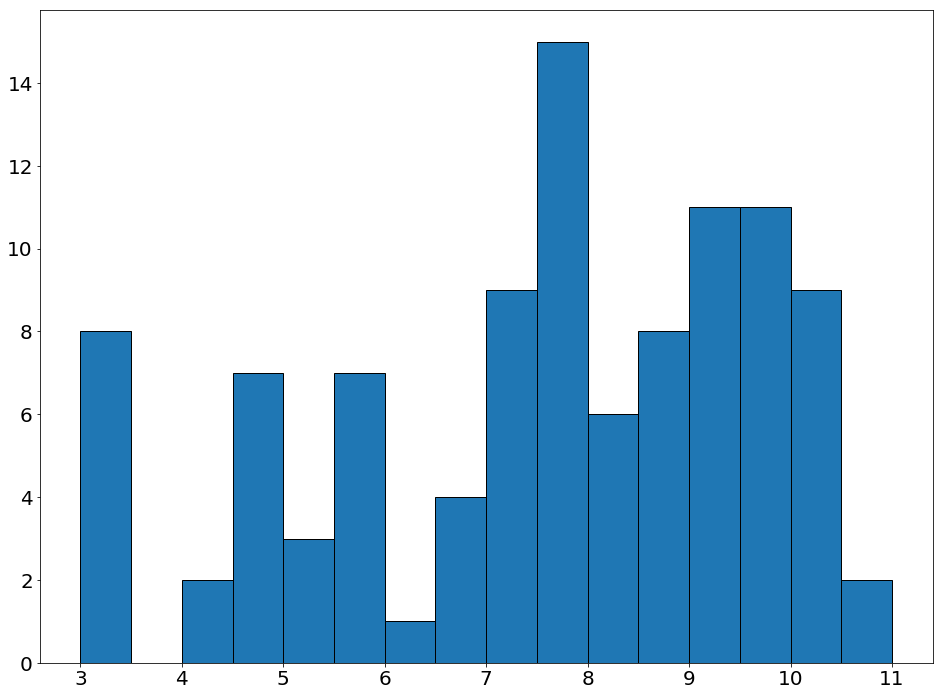

In [141]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,12))
plt.hist(distance, range=(3,11), bins=16, histtype='bar', ec='black');
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 

In [62]:
lattice_sites['site_index'] = lattice_sites.groupby('atom').cumcount()

In [64]:
def write_cif(filepath, lattice_sites,structure_sites,Al_sites):
    if os.path.isfile(filepath):
        os.remove(filepath)
    with open(filepath, 'a') as file:
        file.write('''data_image0
    _cell_length_a       {}
    _cell_length_b       {}
    _cell_length_c       {}
    _cell_angle_alpha    {}
    _cell_angle_beta     {}
    _cell_angle_gamma    {}

    _symmetry_space_group_name_H-M    "P 1"
    _symmetry_int_tables_number       1

    loop_
      _symmetry_equiv_pos_as_xyz
      'x, y, z'

    loop_
      _atom_site_label
      _atom_site_occupancy
      _atom_site_fract_x
      _atom_site_fract_y
      _atom_site_fract_z
      _atom_site_thermal_displace_type
      _atom_site_B_iso_or_equiv
      _atom_site_type_symbol\n'''.format(lattice['a'], lattice['b'], lattice['c'], lattice['alpha'], lattice['beta'], lattice['gamma']))
        for index, row in structure_sites.iterrows():
            if index in Al_sites:
                file.write('  {}{} 1.0000 {:0.5f} {:0.5f} {:0.5f} Biso 1.000 {}\n'.format(row.atom.split(',')[0], index+1, row.a, row.b, row.c, row.atom.split(',')[1]))
            else:
                file.write('  {}{} 1.0000 {:0.5f} {:0.5f} {:0.5f} Biso 1.000 {}\n'.format(row.atom.split(',')[0], index+1, row.a, row.b, row.c, row.atom.split(',')[0]))
        for index, row in lattice_sites.iterrows():
            if row.atom == 'O':
                file.write('  {}{} 1.0000 {:0.5f} {:0.5f} {:0.5f} Biso 1.000 {}\n'.format(row.atom.split(',')[0], row.site_index+1, row.a, row.b, row.c, row.atom.split(',')[0]))
        return

In [65]:
write_cif('all_sites.cif', lattice_sites, structure_sites, [])

In [155]:
for pair in temp:
    cluster_type = cluster_type_dict[pair]
    d = lat_clusters[cluster_type.split(' or ')[0]]['max_d']
    print(d)
    filepath = '{}-{}/{}-d{:.2f}.cif'.format(int(d), int(d)+1,cluster_type, d)
    write_cif(filepath, lattice_sites, structure_sites, list(pair))

10.32152
8.82806
8.86399
3.1097
7.52765
5.73264
3.11292
10.18163
9.65878
3.16845
9.47259
10.00055
8.19438
9.47408
10.67563
7.52534
3.20643
9.43007
9.79438
9.36082
10.32719
8.98823
8.17959
7.72171
5.77269
8.46461
8.95494
10.32177
9.42031
3.21586
9.96998
10.53571
3.11443
9.28281
7.92699
7.04678
7.541
6.42776
7.91808
9.5791
7.541
9.06914
7.66647
7.44053
6.67912
8.85071
7.36892
7.56907
4.59302
9.69441
5.38325
9.49688
6.56844
5.60446
10.0736
6.83499
9.80965
3.14223
7.40029
9.63092
7.541
5.77479
4.82425
7.24076
8.58473
4.84367
9.95712
8.01365
4.8425
8.18588
10.251
7.7191
4.91182
4.65993
7.48012
7.3816
4.82105
5.59372
8.56556
7.55676
7.83581
4.42657
7.27543
6.55853
9.11651
9.75375
7.541
8.98886
5.29331
7.45289
9.26532
8.13725
4.42808
5.11578
5.78847
9.13221
9.87636
10.0546
3.16551
7.50774
9.56034
10.29909
5.90699
